<a name="top"> <h1>3.6. XGBoost Model</h1> <a>

<p>Yelp Dataset- Stars Prediction<br />
<strong>Aprendizaje Autom&aacute;tico</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>

<p>&nbsp;</p>

<p style="text-align:right">Antonio Nogués Podadera (<em>antonio.nogues@cunef.edu</em>)</p>
<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>

<hr style="border:1px solid gray">

[0. Introducción](#introduccion) 


[1. Importación de librerias y funciones](#librerias) 


[2. Carga de datos](#datos) 

[3. Creación del modelo](#creacion) 

   
[4. Optimización del modelo](#optimizacion) 

   
[5. Predicción del modelo](#prediccion)

[6. Evaluación de las métricas del modelo](#metricas)

   - Matriz de confusión
   - Métricas: Accuracy, Recall, Precision, F0.5 y F1
   - Curva ROC y Lift

<hr style="border:1px solid gray">

# <a name="introduccion"> 0. Introducción <a> 


En este documento, nos centraremos en la creación de un **Modelo XGBoost**.


XGBoost es la abreviatura de las palabras inglesas "extreme gradient boosting" (refuerzo de gradientes extremo). Este método se basa en árboles de decisión y supone una mejora sobre otros métodos. Funciona bien con datasets grandes y complejos al utilizar varios métodos de optimización.

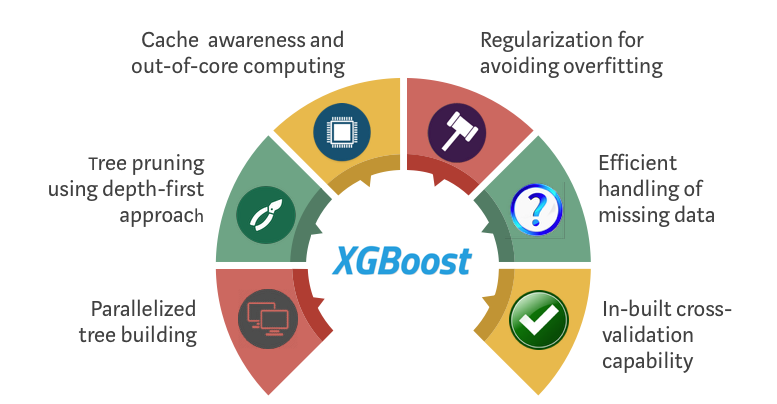

Una vez creado el modelo, procederemos a optimizarlo con los valores de train y predecir los valores de validación.


# <a name="librerias"> 1. Importación de librerias y funciones <a> 


Importamos las librerias necesarias para la creación y optimización del modelo XGBoost:

In [1]:
# Import basic libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Import sklearn metrics.

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, fbeta_score
from sklearn.metrics import plot_confusion_matrix
import scikitplot as skplt
from sklearn.metrics import precision_recall_curve

# Import sklearn models and pipeline.

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier


Importamos las funciones a utilizar:

In [2]:
from aux_functions import load_model, save_model

Cargamos el pickle de preprocesado, para su posterior uso:

In [3]:
#Load the preprocessor.

preprocessor = load_model('../models/preprocessor.pickle')

# <a name="datos"> 2. Carga de datos <a> 

En primer lugar procederemos a cargar los datos de train y validación que insertaremos dentro del modelo para su optimización y predicción.

In [4]:
# Load the train dataset separated by other variables and target. 
x_train = pd.read_parquet("../data/processed/x_train.parquet").reset_index(drop=True)
y_train = pd.read_parquet("../data/processed/y_train.parquet").reset_index(drop=True)

# Load the validation dataset separated by other variables and target. 

x_val = pd.read_parquet("../data/processed/x_val.parquet")
y_val = pd.read_parquet("../data/processed/y_val.parquet")

# <a name="creacion"> 3. Creación del modelo <a> 

Para la creación del modelo **XGBOOST**  utilizaremos el algoritmo _XGBClassifier_ de la libreria _XGBoost_.

Creamos un Pipeline que junte el preprocesado y el algoritmo _XGBClassifier_para ejecutarlo en el orden mencionado.

Para el algoritmo designaremos los parámetros por default, pero utilizaremos todo el procesador para agilizar el proceso. En el caso de que obtenga muy buen resultado, estudiaresmo como modificar los hiperparámetros para tratar de mejorarlo.

In [5]:
# Design the parameters.

n_jobs = -1
random_state = 12345

# Create a pipeline that applies a preprocess of the data and then the LogisticRegression model.

xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('clasificador', XGBClassifier(n_jobs=n_jobs, random_state=random_state)
    )
])


# <a name="optimizacion"> 4. Optimización del modelo <a> 

Optimizamos el modelo a través del pipeline creado anteriormente, para ello introduciremos los valores de train.

In [11]:
# Optimization of the xgboost_model with the train set: input and target data. 

xgb_model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('short_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant',
                                                                                 verbose='deprecated')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse='deprecated'))]),
                                                  ['attributes_ByAppointmentOnly',
                                                   'attributes_BusinessAcceptsCreditCards',
                                                   'attribut

Una vez optimizado el modelo XGB, con el set de train, procedemos a guardarlo en un pickle para que no se tenga que volver a computarlo en un futuro, por si quisieramos usarlo.

In [14]:
# Save the backup of the XGB optimziation as a pickle file.

save_model(xgb_model,'../models/xgb_model.pickle')

**Para evitar optimizar de nuevo el modelo, ejecutar a partir de la celda que aparece a continuación.**

In [6]:
# Load the XGB model already fitted in /models.

xgb_model = load_model('../models/xgb_model.pickle')

# <a name="prediccion"> 5. Predicción del modelo <a> 

Una vez realizada la optimización del modelo XGB, procederemos a predecir el set de validación, sus valores y probabilidades. Para posteriormente obtener las métricas y observar como se comporta el modelo y su score.

In [7]:
# Predict the target value of the validation set.

predictions = xgb_model.predict(x_val)

# Predict the probabilities of the target value for the validation set.

predict_probabilities = xgb_model.predict_proba(x_val)

Una vez obtenidas las probabilidades, representamos el histograma de densidad de la predicción:

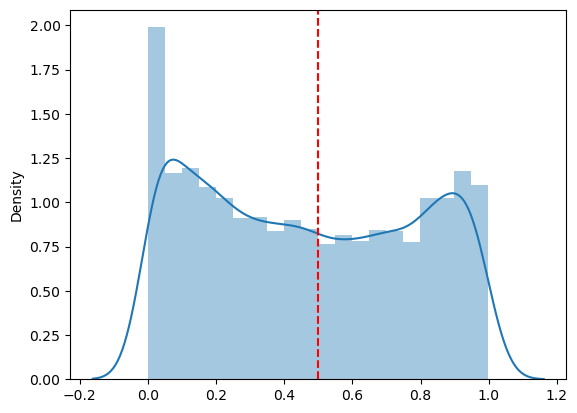

In [8]:
# Parametric density histogram of the predicted probabilities, shwoing the treshold of 0.5.

sns.distplot(predict_probabilities[:,1], kde=True, rug=False, bins=20)
plt.axvline(x=0.5, color='r', linestyle='--')
plt.show()

Observando el histograma de densidad de las probabilidades observamos como el modelo asigna a un mayor número de observaciones probabilidades bajas.

# <a name="metricas"> 6. Evaluación de las métricas del modelo <a> 

En este apartado procederemos a análizar las métricas obtenidas. Nos centraremos principalmente en la métrica F0.5 , dado que es la que mejor refleja los resultados del modelo para nuestro problema. En el caso de que se quiera consultar la definición de cada una de ellas, se pueden encontrar en el documento `02_DummyModel`. 

### 6.1. Matriz de confusión

Confusion matrix, without normalization
[[2648  777]
 [ 869 2178]]
Normalized confusion matrix
[[0.77313869 0.22686131]
 [0.28519856 0.71480144]]


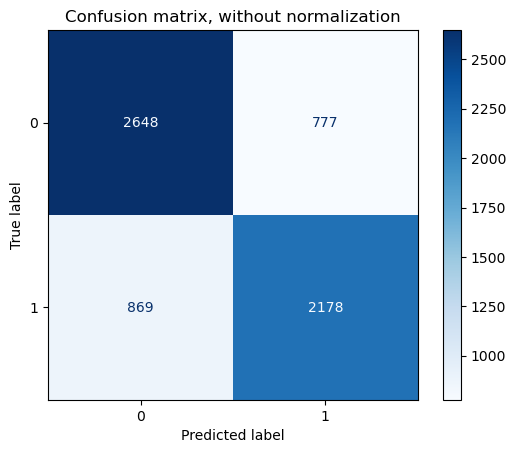

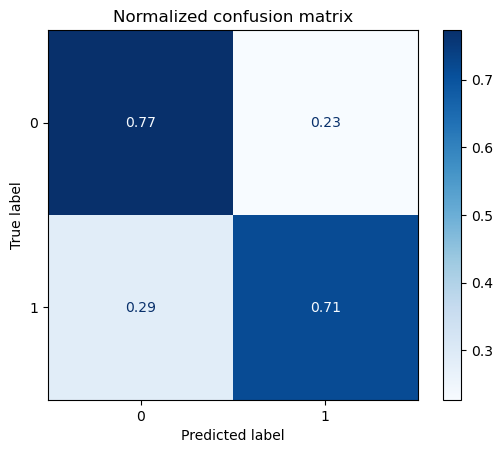

In [9]:
# List with the titles and parameters

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

# Plot the confusion matrix

for title, normalize in titles_options:
    disp = plot_confusion_matrix(xgb_model, x_val, y_val,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

La matriz de confusión es similar a los anteriores modelos. Presenta unos resultados similares, puesto que la clase 1 que es la que realmente nos interesa identificar lo hace en un **71%** de los casos. 

### 6.2. Métricas: Accuracy, Recall, Precision, F0.5 y F1 score

In [12]:
# Print the general metrics.

print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      3425
           1       0.74      0.71      0.73      3047

    accuracy                           0.75      6472
   macro avg       0.74      0.74      0.74      6472
weighted avg       0.75      0.75      0.75      6472



In [10]:
# Model Accuracy

print("Accuracy:",metrics.accuracy_score(y_val, predictions))

# F 0.5 score.

print('F0.5 score is ' +str(fbeta_score(y_val, predictions, average='binary', beta=0.5)))

Accuracy: 0.7456736711990112
F0.5 score is 0.7324947871123966


Para poder reflejar la capacidad predictora del modelo utilizaremos el Accuracy y el Recall.

- El modelo nos calcula un **Recall de 0.74**, por lo que el modelo es capaz de identificar un 74% de casos en los que hay una valoración alta. 


- El modelo nos calcula un **Accuracy de 0.74**, por lo que el modelo es capaz de acertar en el 74% de los casos. 


- **El modelo nos calcula un F0.5 de 0.73, por lo que el modelo es capaz de diferenciar falsos positivos en el 73% de los casos. Esta medida es la que utilizaremos para compararlo con el resto de modelos**

### 6.3. Curva ROC y Lift

Para evaluar nuestro modelo, la representaremos graficamente para deducir que tan bueno es el modelo.

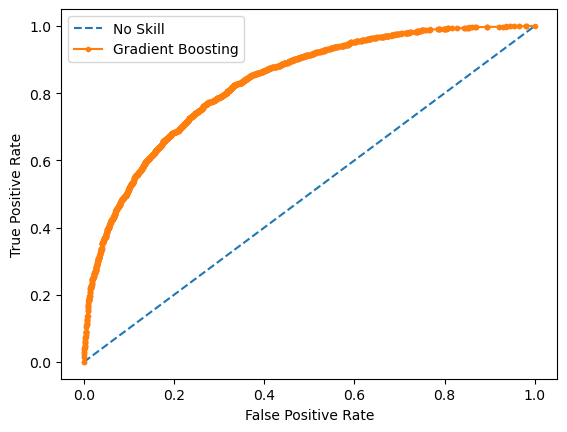

The Compute Area Under the Receiver Operating Characteristic is 0.8305321256518916


In [14]:
# Keep probabilities for the positive outcome only
yhat = predict_probabilities[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_val, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Gradient Boosting')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# Show the plot
plt.show()

# Display the ROC AUC.

print('The Compute Area Under the Receiver Operating Characteristic is '+ str(metrics.roc_auc_score(y_val,yhat)))

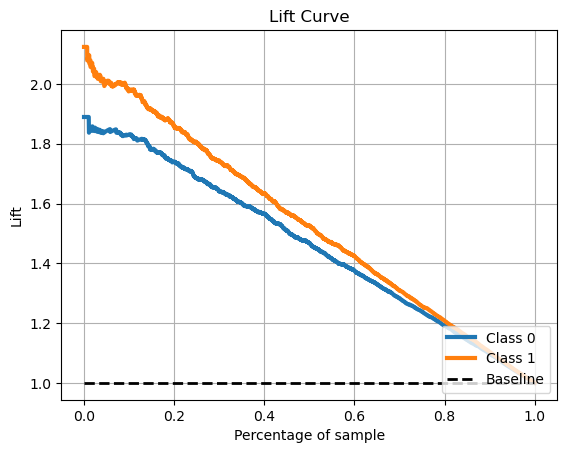

In [18]:
# Plot the lift curve.

skplt.metrics.plot_lift_curve(y_val, predict_probabilities)
plt.show()

**La curva ROC presenta un resultado muy bueno, puesto que se encuentra muy cerca del punto (0,1). El área bajo la curva es de un 0.83.**

 En cuanto a la curva lift, podemos observar que el modelo es muy similar a los modelos estudiados previamente.

[Ir arriba del documento](#top)